# Random instanton approximation
The programme studies the random instanton approximation, also known as instanton gas model, in which we consider an ensemble of instanton configurations with negligible instanton interactions. The partition function of such a system is given by:

$$
Z=\sum_{n_I, n_A}\frac{\delta_{n_I,\, n_A}}{n_I!\, n_A!}\left(\prod\int d\tau_i\right)e^{-S_0}
$$

where $n_I$, $n_A$ are the number of instantons and anti-instantons, $\tau_i$ are the instanton and anti-instanton positions, and $S_0$ is the classical action.

Input parameters, with default values:
- potential parameters: $\lambda=1$, $\eta=1.4$
- mass of the particle: $m=0.5$
- number of lattice points: $N=800$
- lattice spacing: $a=0.05$
- number of Metropolis sweeps: $N_{sweeps}=100$
- number of instantons in the sum ansatz: $N_{in}=10$
- number of heating steps: $N_{heat}=10$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import math
import random
from tqdm.notebook import tqdm
from mpl_toolkits import mplot3d
from matplotlib import cm

In [2]:
# Parameters of the potential
Lambda = float(input("lambda = ") or 1);
eta = float(input("eta = ") or 1.4);
m = float(input("m = ") or 1/2);
hbar = 1;

lambda = 
eta = 
m = 


In [3]:
# Lattice parameters
N = int(input("N = ") or 800);
a = float(input("a = ") or 0.05);
Nsweeps = int(input("Nsweeps = ") or 100);

N = 
a = 
Nsweeps = 


### Estimate of the number of instantons
To get a rough estimate of the number of instantons we can exploit the semiclassical approximation, which gives the instanton density $n_I$ ($\beta n_I= N_{in}$) as a function of $\eta$ and works quite well for values of $\eta \gtrsim 1$:
$$
n_I=8\eta^{\frac{5}{2}}\sqrt{\frac{2}{\pi}}\ \exp{\left(-S_0-\frac{71}{72S_0}\right)}\qquad\mbox{where}\qquad
S_0=\frac{4\eta^3}{3}
$$

In [4]:
# Number of instantons, semiclassical estimate
S0 = 4*eta**3/3;
instdens1 = 8*np.sqrt(2/np.pi)*eta**2.5*np.exp(-S0);           # One-loop
instdens2 = instdens1*np.exp(-71/(72*S0));                     # Two-loop

beta = N*a;                     # Total euclidean time
Nin1 = instdens1*beta;
Nin2 = instdens2*beta;

Nin_exp1 = round(Nin1)          # Expected number of instantons
Nin_exp2 = round(Nin2)

print('One-loop estimate: Nin = '+str(Nin_exp1))
print('Two-loop estimate: Nin = '+str(Nin_exp2))

Nin = int(input("Nin = ") or Nin_exp2);

One-loop estimate: Nin = 15
Two-loop estimate: Nin = 12
Nin = 


## Exact diagonalization

In [5]:
Ngrid = int(input("Ngrid = ") or 800);
xmin = float(input("xmin = ") or -5);
xmax = float(input("xmax = ") or 5);

tau_vec = np.linspace(0, N*a, N);          # Total euclidean time obtained from lattice spacing a and from N

# Potential
xvec = np.linspace(xmin, xmax, Ngrid);     # Vector spanning from xmin to xmax with Ngrid points
Vx = Lambda*(xvec**2-eta**2)**2;

# Kinetic energy discretization
dx = np.diff(xvec).mean();     # Grid resolution
diag = -2*np.ones(Ngrid);      # -2f(x)
offdiag = np.ones(Ngrid-1);    # f(x+dx) and f(x-dx)

d2grid = np.mat(np.diag(diag,0) + np.diag(offdiag,-1) + np.diag(offdiag,1))/dx**2;     # Discretized second derivative

# Avoid problems at the edge of the grid
d2grid[0,:] = 0;
d2grid[Ngrid-1,:] = 0;

Ekin = -hbar**2/(2*m)*d2grid;

# Potential energy discretization
Epot = np.mat(np.diag(Vx, 0))

# Total Hamiltonian diagonalization
H = Ekin + Epot;
w, v = LA.eig(H);

sortinds = np.argsort(w);     # Returns the indices that would sort the array w
EigVals = w[sortinds];        # Eigenvalues sorting
EigVecs = v[:,sortinds];      # Corresponding eigenvectors sorting

Ngrid = 
xmin = 
xmax = 


In [6]:
# Function that evaluates the braket in the above expression for G
def Compute_xvalues(v):
    w = 4*eta;                       # Frequency of the corresponding harmonic oscillator
    rho = np.zeros((N, 3));          # Initialize the density of states
    
    for n in tqdm(range(N), leave = False):         # Loop over all lattice points
        cn = 0;
        dn = 0;
        en = 0;
        
        for k in range(N):           # Loop over all eigenvalues
            km3 = max(k-3, 0);       # Conditions to ensure that the square roots exist
            km2 = max(k-2, 0);
            km1 = max(k-1, 0);
            kp1 = min(k+1, N-1);
            kp2 = min(k+2, N-1);
            kp3 = min(k+3, N-1);
            
            # Expressions coming from analytic computation of the braket, here cn = <0|x|n> ecc.
            cn = cn + ( np.sqrt(k)*v[km1, 0] + np.sqrt(k+1)*v[kp1, 0] )*v[k, n];
            dn = dn + ( np.sqrt(k*(k-1))*v[km2, 0] + (2*k+1)*v[k, 0] + np.sqrt((k+1)*(k+2))*v[kp2, 0] )*v[k, n];
            en = en + ( np.sqrt(k*(k-1)*(k-2))*v[km3, 0] + 3*k*np.sqrt(k)*v[km1, 0] + 3*(k+1)*np.sqrt(k+1)*v[kp1, 0] \
                    + np.sqrt((k+1)*(k+2)*(k+3))*v[kp3, 0] )*v[k, n];
            
        rho[n, 0] = 1/(m*w)/2*cn**2;
        rho[n, 1] = 1/(m*w)**2/4*dn**2;
        rho[n, 2] = 1/(m*w)**3/8*en**2;
        
    return rho
            

# Function that evaluates the two-point correlation function from exact diagonalization
def ComputeG_exact():
    G_exact = np.zeros((N, 3));                        # Here Ncf = 3 for simplicity
    rho = Compute_xvalues(EigVecs);
    
    for n in range(N):
        for k in range(N):                
            for j in range(3): 
                if rho[k, j] > 1:                      # Empirical cutoff to avoid divergences
                    rho[k, j] = j+0.5-0.7*j;
                    
                G_exact[n, j] = G_exact[n, j] + rho[k, j] * np.exp(-(EigVals[k]-EigVals[0])*tau_vec[n]);              
                
    return G_exact

G_exact = ComputeG_exact();

  0%|          | 0/800 [00:00<?, ?it/s]

## Sum ansatz
The simplest multi-instanton configuration to start with is the following sum ansatz:

$$
x_{sum}(\tau)=\eta\left\{\sum_i Q_i\tanh{\left[\frac{\omega}{2}(\tau-\tau_i)\right]}-1\right\}
$$

where $Q_i$ is the topological charge of the instanton, which we will set $Q_i\equiv 1$, and $\tau_i$ is its centre. We generate a random sum ansatz by setting the instanton positions as $z_j=r_j\beta$, where $r_j$ is a random number, $j=1,\dots,N_{in}$, and $\beta=Na$ is the total euclidean time. The $z$ vector is then ordered such that $z_j<z_h$ for $j<h$, to reproduce the correct form of the path.

In [7]:
# Fixing the instanton positions randomly
def setup(Nin, z, beta):    
    for j in range(Nin):
        z[j] = random.random()*beta;    # Random instanton positions collected in vector z
    
    z = sorted(z);                      # Sorting the instanton positions

The sum ansatz is then built by introducing an instanton anti-instanton pair every two values among the integers less or equal to $N_{in}$, starting from the initial value $x_{sum}(\tau)=-\eta$ given by the formula above. Taking $\omega=4\eta$ as usual, we get:

$$
x_{sum}(\tau)=\eta\left\{\sum_i \tanh{\left[2\eta(\tau-\tau_i)\right]}-1\right\} = \eta\left\{\sum_{j=1}^{\frac{1}{2}[N_{in}]} \tanh{\left[2\eta\left(\tau-z_{2j-1}\right)\right]}-\tanh{\left[2\eta\left(\tau-z_{2j}\right)\right]}-1\right\}
$$

If $N_{in}$ is odd, an extra term needs to be included not to neglect the last instanton:

$$
x_{added} = \eta\tanh{\left[2\eta\left(\tau-z_{N_{in}}\right)\right]} + \eta
$$

In [8]:
# Function that generates the sum ansatz
def sum_ans(Nin, z, eta, t):
    eta = 1.4;
    Neven = Nin - Nin%2;         # Taking only half of Nin values
    xsum = -eta;                 # Initial value for sum ansatz
    
    for j in range(1, Neven-1, 2):                                                      # Loop every two values of j
        xsum = xsum + eta*np.tanh(2*eta*(t-z[j-1])) - eta*np.tanh(2*eta*(t-z[j]));      # Building the ansatz
    
    if Nin%2 != 0:
        xsum = xsum + eta*np.tanh(2*eta*(t-z[Nin-1])) + eta;                            # Added term
    
    return xsum

### Sample plot
The following code returns an example of random sum ansatz.

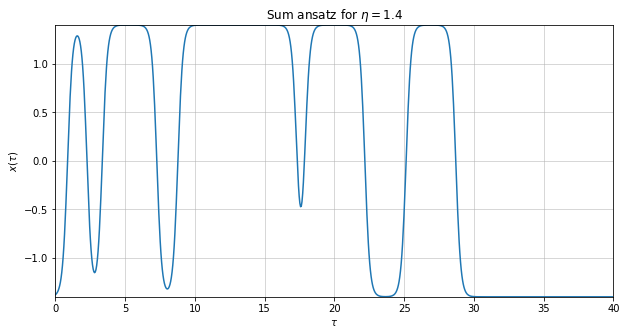

In [9]:
# Building a random sum ansatz
z = np.zeros(Nin);                         # Instanton positions
x = np.zeros(N);                           # Position vector

setup(Nin, z, beta);
z = sorted(z);                             # Sorting the instanton positions
    
for j in range(N):
    xt = a*j;                              # Euclidean time lattice points
    x[j] = sum_ans(Nin, z, eta, xt);       # Corresponding value for the sum ansatz

tau_vec = np.linspace(0, N*a, N);          # Total euclidean time obtained from lattice spacing a and from N

# Plotting the instanton configuration
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(tau_vec, x);
ax.set_xlabel('$\\tau$');
ax.set_ylabel('$x(\\tau)$');
plt.xlim([0, 40])
plt.ylim([min(x), max(x)])
plt.grid(linewidth=0.5);
plt.title('Sum ansatz for $\eta =$'+str(eta));

### Correlation functions computation
The correlations functions can be computed as in Monte Carlo simulations, though considering as configurations the random sum ansatze described before. Each sweep consists then in generating a random sum ansatz, with a fixed instanton number, and evaluating the corresponding correlation functions, which are then averaged over configurations as usual.

In [10]:
Ncf = int(input("Number of correlation functions = ") or 3);

def computeG2(x, dtau, t):
    g = 0;                                     # Initialize the value of the correlation function
    for j in range(N):
        g = g + (x[j]**t)*(x[(j+dtau)%N]**t);  # Add all the terms satisfying the above condition for J
    return g/N

def MCaverage(x):
    G = np.zeros((Nsweeps, N, Ncf))            # Initialize the value of the two-point correlation function
    G1 = np.zeros((Nsweeps, N, Ncf))           # Initialize the value of the one-point correlation function
    
    for k in tqdm(range(Nsweeps), leave = False):
        
        # Generating the sum ansatz as before #############################################################
        
        z = np.zeros(Nin);
        x = np.zeros(N);

        setup(Nin, z, beta);
        z = sorted(z);

        for j in range(N):
            xt = a*j;
            x[j] = sum_ans(Nin, z, eta, xt);
        
        ####################################################################################################

        for t in range(Ncf):                   # Evaluate correlation functions of order t = 1, 2, ..., Ncf
            for n in range(N):
                G[k, n, t] = computeG2(x, n, t+1);
                G1[k, n, t] = x[n]**t/N;

    avg_G = np.zeros((N, Ncf));                # Initialize the value of the average
    avg_G1 = avg_G;                            # (both for one- and two-point correlation functions)
    
    for n in range(N):                         # Compute the Monte Carlo average for each order t
        for t in range(Ncf):
            for k in range(Nsweeps):
                avg_G[n, t] = avg_G[n, t] + G[k, n, t];          # Two-point correlation function
                avg_G1[n, t] = avg_G1[n, t] + G1[k, n, t];       # One-point correlation function
    avg_G = avg_G / Nsweeps;
    avg_G1 = avg_G1 / Nsweeps;
        
    return [avg_G, avg_G1]

# Computing the first Ncf correlation functions
[G_two, G_one] = MCaverage(x)

deltaG = np.sqrt(np.abs(G_two-np.power(G_one, 2)) / Nsweeps);          # Statistical error

Number of correlation functions = 


  0%|          | 0/100 [00:00<?, ?it/s]

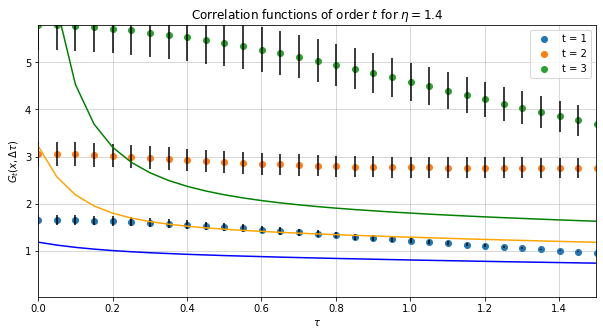

In [11]:
# Plotting the correlation functions
fig, ax = plt.subplots(figsize=(10,5))

for i in range(Ncf):
    ax.plot(tau_vec, G_two[:,i], 'o', label = 't = '+str(i+1))
    plt.errorbar(tau_vec, G_two[:,i], yerr = deltaG[:,i], xerr = None, fmt = 'None', ecolor = 'black')
    
ax. plot(tau_vec, G_exact[:,0], color = 'blue')
ax. plot(tau_vec, G_exact[:,1], color = 'orange')
ax. plot(tau_vec, G_exact[:,2], color = 'green')

ax.set_xlabel('$\\tau$');
ax.set_ylabel('$G_t(x,\Delta\\tau)$');
plt.xlim([0, 1.5]);
plt.ylim([np.min(G_two), np.max(G_two)])
plt.grid(linewidth=0.5);
plt.title('Correlation functions of order $t$ for $\eta =$'+str(eta));
plt.legend()
plt.show()

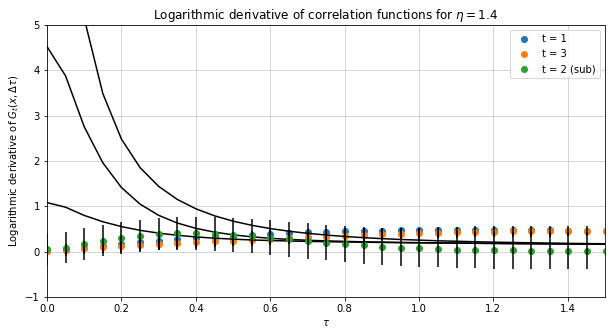

In [12]:
# Function that computes the logarithmic derivative of a vector
# (intended as a function of tau)
def logder(x):
    logx = np.log(x);
    logder = -np.gradient(logx, a);
    return logder

# Plotting the logarithmic derivative of the correlation functions
fig, ax = plt.subplots(figsize=(10,5))

for i in range(0, Ncf, 2):
    ax.plot(tau_vec, logder(np.abs(G_two[:,i])), 'o', label = 't = '+str(i+1))
    
    logG_err = np.zeros((N,3));
    for j in range(N-1):
        logG_err[j,i] = np.square(deltaG[j+1,i] / G_two[j,i]) + np.square(deltaG[j,i]*G_two[j+1,i] / np.square(G_two[j,i]));
        logG_err[j,i] = np.sqrt(logG_err[j,i]);

    plt.errorbar(tau_vec, logder(np.abs(G_two[:,i])), yerr = logG_err[:,i], xerr = None, fmt = 'None', ecolor = 'black')

for i in range(Ncf):
    ax. plot(tau_vec, logder(np.abs(G_exact[:,i])), color = 'black')

# Even-order correlation function with constant value subtracted
Gsub = G_two[:,1] - np.square(G_one[:,1]);
Gsub_err = np.sqrt(np.square(deltaG[:,1]) + np.square(2*G_one[:,1]*deltaG[N-1,1]));   # Error propagation

# Computing the errors of the logarithmic derivative
logG_err = np.zeros(N);
for j in range(N-1):
    logG_err[j] = np.square(Gsub_err[j+1] / Gsub[j]) + np.square(Gsub_err[j]*Gsub[j+1] / np.square(Gsub[j]));
    logG_err[j] = np.sqrt(logG_err[j]);

ax.plot(tau_vec, logder(np.abs(Gsub)), 'o', label = 't = 2 (sub)')
plt.errorbar(tau_vec, logder(np.abs(Gsub)), logG_err, xerr = None, fmt = 'None', ecolor = 'black')

ax.set_xlabel('$\\tau$');
ax.set_ylabel('Logarithmic derivative of $G_t(x,\Delta\\tau)$');
plt.xlim([0, 1.5])
plt.ylim([-1, 5])
plt.grid(linewidth=0.5);
plt.title('Logarithmic derivative of correlation functions for $\eta =$'+str(eta));
plt.legend();
plt.show()

## Heating
We now aim at including quantum fluctuations; in order to do so numerically, we exploit the $\textit{heating}$ method, which is the inverse of the cooling one. Starting from the classical path (sum ansatz) we determine the Gaussian effective potential for small fluctuations around the path; for a single instanton, the action is given by:

$$
S=\int d\tau \left\{\frac{1}{4}\delta\dot{x}^2(\tau)+4\eta^2\left[1-\frac{3}{2\cosh^2{[2\eta(\tau-\tau_i)]}}\right]\delta x^2(\tau)\right\}
$$

### Gaussian effective potential
The following code plots the Gaussian effective potential written above, with $\tau_i\equiv 0$.

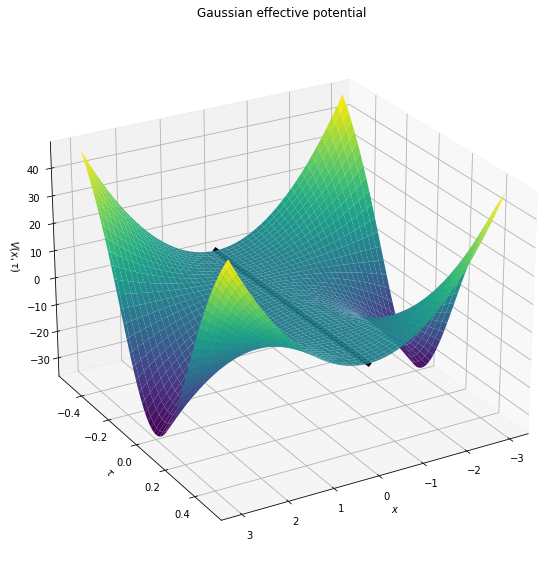

In [13]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = '3d')

xvec = np.linspace(-3, 3, 100);
tvec = np.linspace(-0.5, 0.5, 100);

# Gaussian effective potential, from action principle
def f(X, T, Ti):
    return 4*eta**2*(1-3/(2*(np.cosh(2*eta*(T-Ti)))**2))*X**2

X, T = np.meshgrid(xvec, tvec);
V = f(X, T, 0);                     # The instanton is centred around zero

ax.plot_surface(X, T, V, cmap = 'viridis');
ax.plot(np.zeros(len(tvec)), tvec, f(0,tvec,0), color = 'black', linewidth = 5);
ax.set_xlabel('$x$');
ax.set_ylabel('$\\tau$');
ax.set_zlabel('$V(x,\\tau)$');
plt.title('Gaussian effective potential');

ax.view_init(25, 60)

In [14]:
# Function that evaluates the action of a given configuration considering only j-dependent terms
def S(j, x, eta, w):
    
    if j == N-1:
        Action = ((x[j]-x[j-1])**2 + (x[0]-x[j])**2)/(4*a);
    else:
        Action = ((x[j]-x[j-1])**2 + (x[j+1]-x[j])**2)/(4*a);
    
    w[j] = -4*(eta**2-3*x[j]**2);
    Action = Action + a*0.5*w[j]*(x[j] - x[j])**2;
    
    return Action

In [15]:
eps = float(input("epsilon = ") or 0.1);

# Function that updates x according to Metropolis algorithm
def update(y, w):
    for j in range(N):
        old_y = y[j];                                    # Save the original values
        old_Sj = S(j, y, eta, w);
        y[j] = y[j] + random.gauss(0, eps);              # Update x[j]
        dS = S(j, y, eta, w) - old_Sj;                   # Change in action
        if np.exp(-dS) < random.random():                # Metropolis acceptance criterium
            y[j] = old_y;                                # Restore the old value in case the condition is not satisfied

epsilon = 


### Sample path
The following code produces a sample path with Gaussian fluctuations included.

Nheating = 


  0%|          | 0/10 [00:00<?, ?it/s]

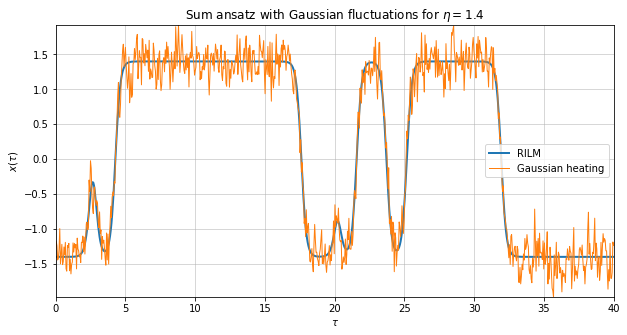

In [16]:
Nheat = int(input("Nheating = ") or 10);

# Random sum ansatz
z = np.zeros(Nin);
x = np.zeros(N);

setup(Nin, z, beta);
z = sorted(z);
    
for j in range(N):
    xt = a*j;
    x[j] = sum_ans(Nin, z, eta, xt);

tau_vec = np.linspace(0, N*a, N);            # Total euclidean time obtained from lattice spacing a and from N

# Plotting the classical instanton configuration
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(tau_vec, x, linewidth = 2, label = 'RILM');

# Heating
x_hot = x;
w = -4*(eta**2-3*x**2);

for h in tqdm(range(Nheat), leave = False):
    update(x_hot, w);                         # Heating steps through Metropolis algorithm

# Plotting the quantum fluctuations
ax.plot(tau_vec, x_hot, linewidth = 1, label = 'Gaussian heating');
ax.set_xlabel('$\\tau$');
ax.set_ylabel('$x(\\tau)$');
plt.xlim([0, 40])
plt.ylim([min(x), max(x)])
plt.grid(linewidth=0.5);
plt.title('Sum ansatz with Gaussian fluctuations for $\eta =$'+str(eta));
plt.legend();
plt.show()

### Correlation functions computation
The correlation functions can be now evaluated including quantum fluctuations.

In [17]:
def MCaverage_heated(x):
    G = np.zeros((Nsweeps, N, Ncf))            # Initialize the value of the two-point correlation function
    G1 = np.zeros((Nsweeps, N, Ncf))           # Initialize the value of the one-point correlation function
    
    for k in tqdm(range(Nsweeps), leave = False):
        
        z = np.zeros(Nin);
        x = np.zeros(N);

        setup(Nin, z, tmax);
        z = sorted(z);

        for j in range(N):
            xx = a*j;
            x[j] = sum_ans(Nin, z, eta, xx);
            
        x_hot = x;
        w = -4*(eta**2-3*x**2);

        for h in tqdm(range(Nheat), leave = False):
            update(x_hot, w);
        
        for t in range(Ncf):                   # Evaluate correlation functions of order t = 1, 2, ..., Ncf
            for n in range(N):
                G[k, n, t] = computeG2(x_hot, n, t+1);
                G1[k, n, t] = x_hot[n]**t;

    avg_G = np.zeros((N, Ncf));                # Initialize the value of the average
    avg_G1 = avg_G;                            # (both for one- and two-point correlation functions)
    
    for n in range(N):                         # Compute the Monte Carlo average for each order t
        for t in range(Ncf):
            for k in range(Nsweeps):
                avg_G[n, t] = avg_G[n, t] + G[k, n, t];          # Two-point correlation function
                avg_G1[n, t] = avg_G1[n, t] + G1[k, n, t];       # One-point correlation function
    avg_G = avg_G / Nsweeps;
    avg_G1 = avg_G1 / Nsweeps;
        
    return [avg_G, avg_G1]

# Computing the first Ncf correlation functions
[G_two, G_one] = MCaverage(x)

deltaG = np.sqrt(np.abs(G_two-np.power(G_one, 2)) / Nsweeps);          # Statistical error

  0%|          | 0/100 [00:00<?, ?it/s]

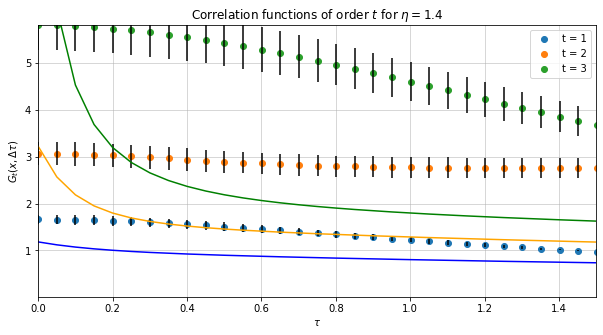

In [18]:
# Plotting the correlation functions
fig, ax = plt.subplots(figsize=(10,5))

for i in range(Ncf):
    ax.plot(tau_vec, G_two[:,i], 'o', label = 't = '+str(i+1))
    plt.errorbar(tau_vec, G_two[:,i], yerr = deltaG[:,i], xerr = None, fmt = 'None', ecolor = 'black')
    
ax. plot(tau_vec, G_exact[:,0], color = 'blue')
ax. plot(tau_vec, G_exact[:,1], color = 'orange')
ax. plot(tau_vec, G_exact[:,2], color = 'green')

ax.set_xlabel('$\\tau$');
ax.set_ylabel('$G_t(x,\Delta\\tau)$');
plt.xlim([0, 1.5]);
plt.ylim([np.min(G_two), np.max(G_two)])
plt.grid(linewidth=0.5);
plt.title('Correlation functions of order $t$ for $\eta =$'+str(eta));
plt.legend()
plt.show()

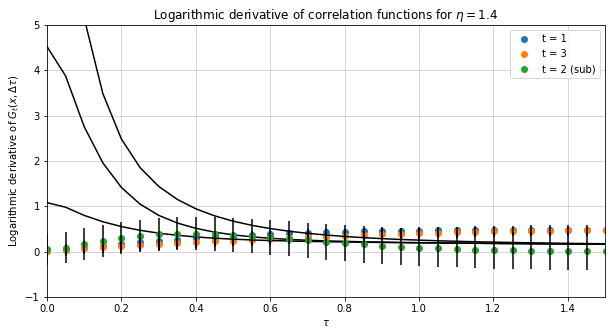

In [19]:
# Plotting the logarithmic derivative of the correlation functions
fig, ax = plt.subplots(figsize=(10,5))

for i in range(0, Ncf, 2):
    ax.plot(tau_vec, logder(np.abs(G_two[:,i])), 'o', label = 't = '+str(i+1))
    
    logG_err = np.zeros((N,3));
    for j in range(N-1):
        logG_err[j,i] = np.square(deltaG[j+1,i] / G_two[j,i]) + np.square(deltaG[j,i]*G_two[j+1,i] / np.square(G_two[j,i]));
        logG_err[j,i] = np.sqrt(logG_err[j,i]);

    plt.errorbar(tau_vec, logder(np.abs(G_two[:,i])), yerr = logG_err[:,i], xerr = None, fmt = 'None', ecolor = 'black')

for i in range(Ncf):
    ax. plot(tau_vec, logder(np.abs(G_exact[:,i])), color = 'black')

# Even-order correlation function with constant value subtracted
Gsub = G_two[:,1] - np.square(G_one[:,1]);
Gsub_err = np.sqrt(np.square(deltaG[:,1]) + np.square(2*G_one[:,1]*deltaG[N-1,1]));   # Error propagation

# Computing the errors of the logarithmic derivative
logG_err = np.zeros(N);
for j in range(N-1):
    logG_err[j] = np.square(Gsub_err[j+1] / Gsub[j]) + np.square(Gsub_err[j]*Gsub[j+1] / np.square(Gsub[j]));
    logG_err[j] = np.sqrt(logG_err[j]);

ax.plot(tau_vec, logder(np.abs(Gsub)), 'o', label = 't = 2 (sub)')
plt.errorbar(tau_vec, logder(np.abs(Gsub)), logG_err, xerr = None, fmt = 'None', ecolor = 'black')

ax.set_xlabel('$\\tau$');
ax.set_ylabel('Logarithmic derivative of $G_t(x,\Delta\\tau)$');
plt.xlim([0, 1.5])
plt.ylim([-1, 5])
plt.grid(linewidth=0.5);
plt.title('Logarithmic derivative of correlation functions for $\eta =$'+str(eta));
plt.legend();
plt.show()